# Cell type assignment

In this notebook, we analyse the cell type predictions of the automated annotation model and validate its cell type assignments using marker gene expression and other sources of information (e.g. knowledge of developmental stages and anatomical dissections).  

In [17]:
import importlib
import scrabbit #import the module here, so that it can be reloaded.
importlib.reload(scrabbit.annotate)

<module 'scrabbit.annotate' from 'g:\\my drive\\postgrad\\phd\\projects\\rabbit-gastrulation-atlas\\scrabbitpy\\src\\scrabbit\\annotate.py'>

In [18]:
import scrabbit
from scrabbit.annotate import *
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import math
from ipywidgets.widgets import HBox

seed = 0
seedB = 42

sc.set_figure_params(dpi=150,dpi_save=300)


In [2]:
from scrabbit.plot_utils import *

## Load data

In [3]:
# Load data
r_data = sc.read_h5ad("../data-in/cell_type_annotation/rabbit_corrected_clustered.h5ad")
orthologs = pd.read_csv("../data-in/orthologs/rabbit_mouse_orthologs.tsv", sep="\t")


In [4]:
# TODO make gene names default var.index for r_data
r_genes = pd.read_csv("../data-in/raw/genes.tsv", sep="\t")
r_data.var.index = r_genes["gene_name"]


In [5]:
# TODO add this as default for r_data
#r_data.obs["anatomical_loc"] = r_data.obs["anatomical_loc"].astype("str")
r_data.obs["anatomical_loc"] = ""

# Add anatomical location info
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([12,16])] = "Head"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([13,17])] = "Trunk"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([14,18])] = "Tail"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([15,19,22,26])] = "Yolk sac"
r_data.obs["anatomical_loc"][~r_data.obs["sample"].isin([12,16,13,17,14,18,15,19,22,26])] = "Whole embryo"
r_data.obs["anatomical_loc"] = r_data.obs["anatomical_loc"].astype("category")
r_data.obs["anatomical_loc"] = r_data.obs["anatomical_loc"].cat.reorder_categories(["Head", "Trunk", 
                                                                                    "Tail","Yolk sac",
                                                                                    "Whole embryo"])

anatomy_colours = {
    "Head":"red",
    "Trunk": "blue",
    "Tail": "green",
    "Yolk sac": "orange",
    "Whole embryo": "grey"
}
r_data.uns["anatomical_loc_colors"] = [anatomy_colours[x] for x in r_data.obs["anatomical_loc"].cat.categories]

C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_27024/1539020577.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([12,16])] = "Head"
C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_27024/1539020577.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([13,17])] = "Trunk"
C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_27024/1539020577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [6]:
m_markers = pd.read_csv("../data-in/cell_type_annotation/celltype_markers.tsv", sep="\t")
m_markers = {i: m_markers[i].dropna().to_list() for i in m_markers.columns}


In [7]:
orthologs_copy = orthologs
orthologs_copy.index = orthologs_copy["mouse_gene_name"]
r_markers = {i: list(orthologs_copy.loc[[x for x in m_markers[i] if x in orthologs_copy["mouse_gene_name"]] ,"rabbit_gene_name"]) for i in list(m_markers.keys())  }


## Cluster data

Cell type labels are assigned to clusters identified in the high-dimensional gene expression space. Here we perfrom Leiden clustering at various resolutions to identify both coarse and fine-grained populations of cells.

For the sake of brevity, here we have used precomputed clusterings. See `scripts/cluster.py` to run the full clustering.  

In [ ]:
# Load clusters from file
clusters = pd.read_csv("../data-in/cell_type_annotation/clusters.tsv",sep="\t")
r_data.obs = r_data.obs.join(clusters)


## Divide dataset

To simplify the annotation process, the dataset is initially divded into broad regions to be annotated separately. 

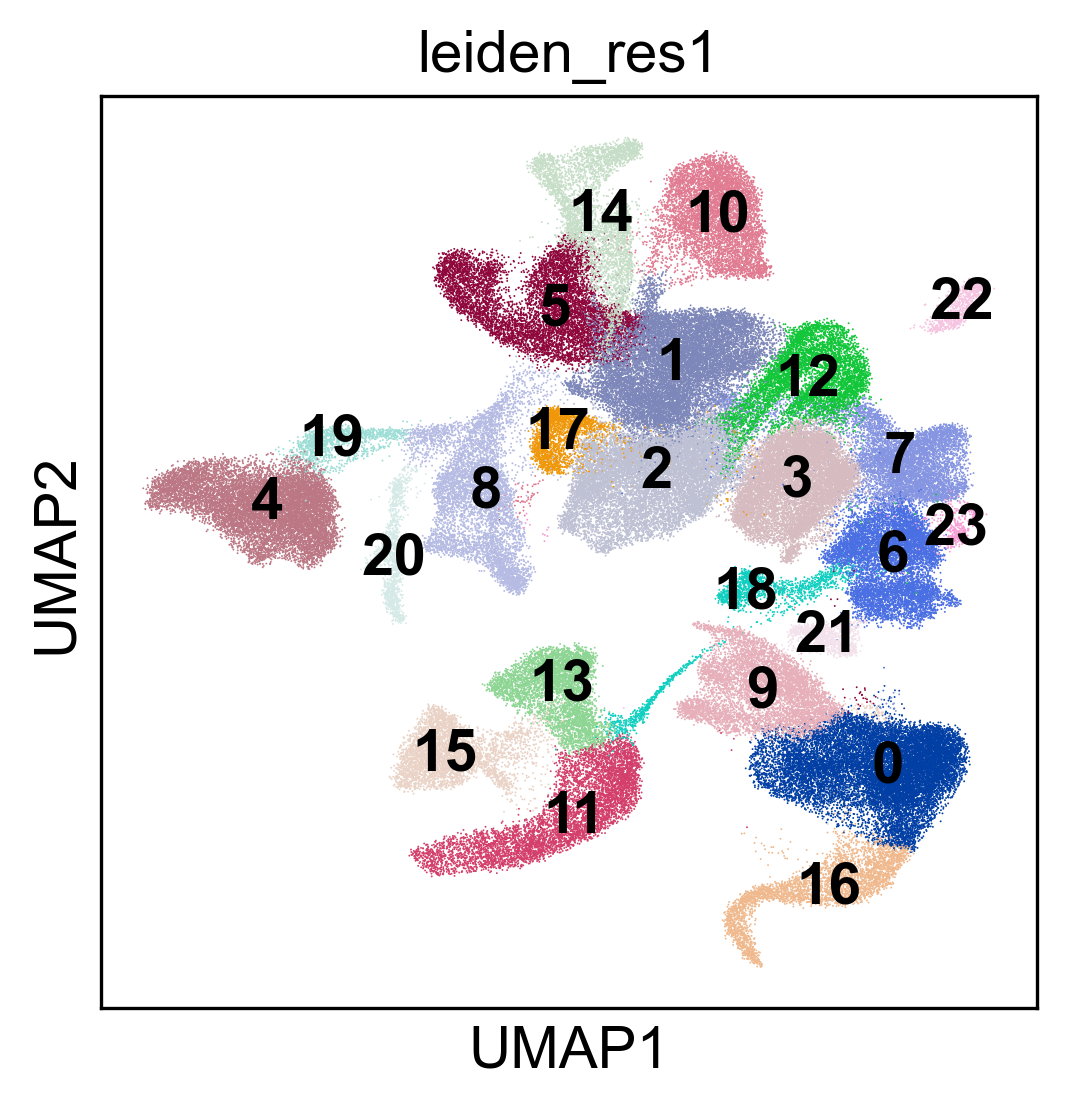

In [49]:
sc.pl.umap(r_data,color=["leiden_res1"],legend_loc="on data")

In [8]:
r_blood = r_data[r_data.obs["leiden_res1"].isin(['4','19','20','8']),]
r_meso = r_data[r_data.obs["leiden_res1"].isin(['2','12','22','1']),]
r_neural = r_data[r_data.obs["leiden_res1"].isin(['3','7','17']),]
r_misc = r_data[r_data.obs["leiden_res1"].isin(['6','23','21','18']),]
r_exeEcto = r_data[r_data.obs["leiden_res1"].isin(['9','0','16']),]
r_exeMeso = r_data[r_data.obs["leiden_res1"].isin(['5','14','10']),]
r_exeEndo = r_data[r_data.obs["leiden_res1"].isin(['13','15','11']),]



## Useful plots

For each broad region, we plot the automated annotation predictions, along with clusterings of different resolutions. These results are compared to UMAP plots of marker gene expression and are cross-validated with other sources of information such as the developmental stage and anatomical dissection.


<AxesSubplot:title={'center':'anatomical_loc'}, xlabel='UMAP1', ylabel='UMAP2'>

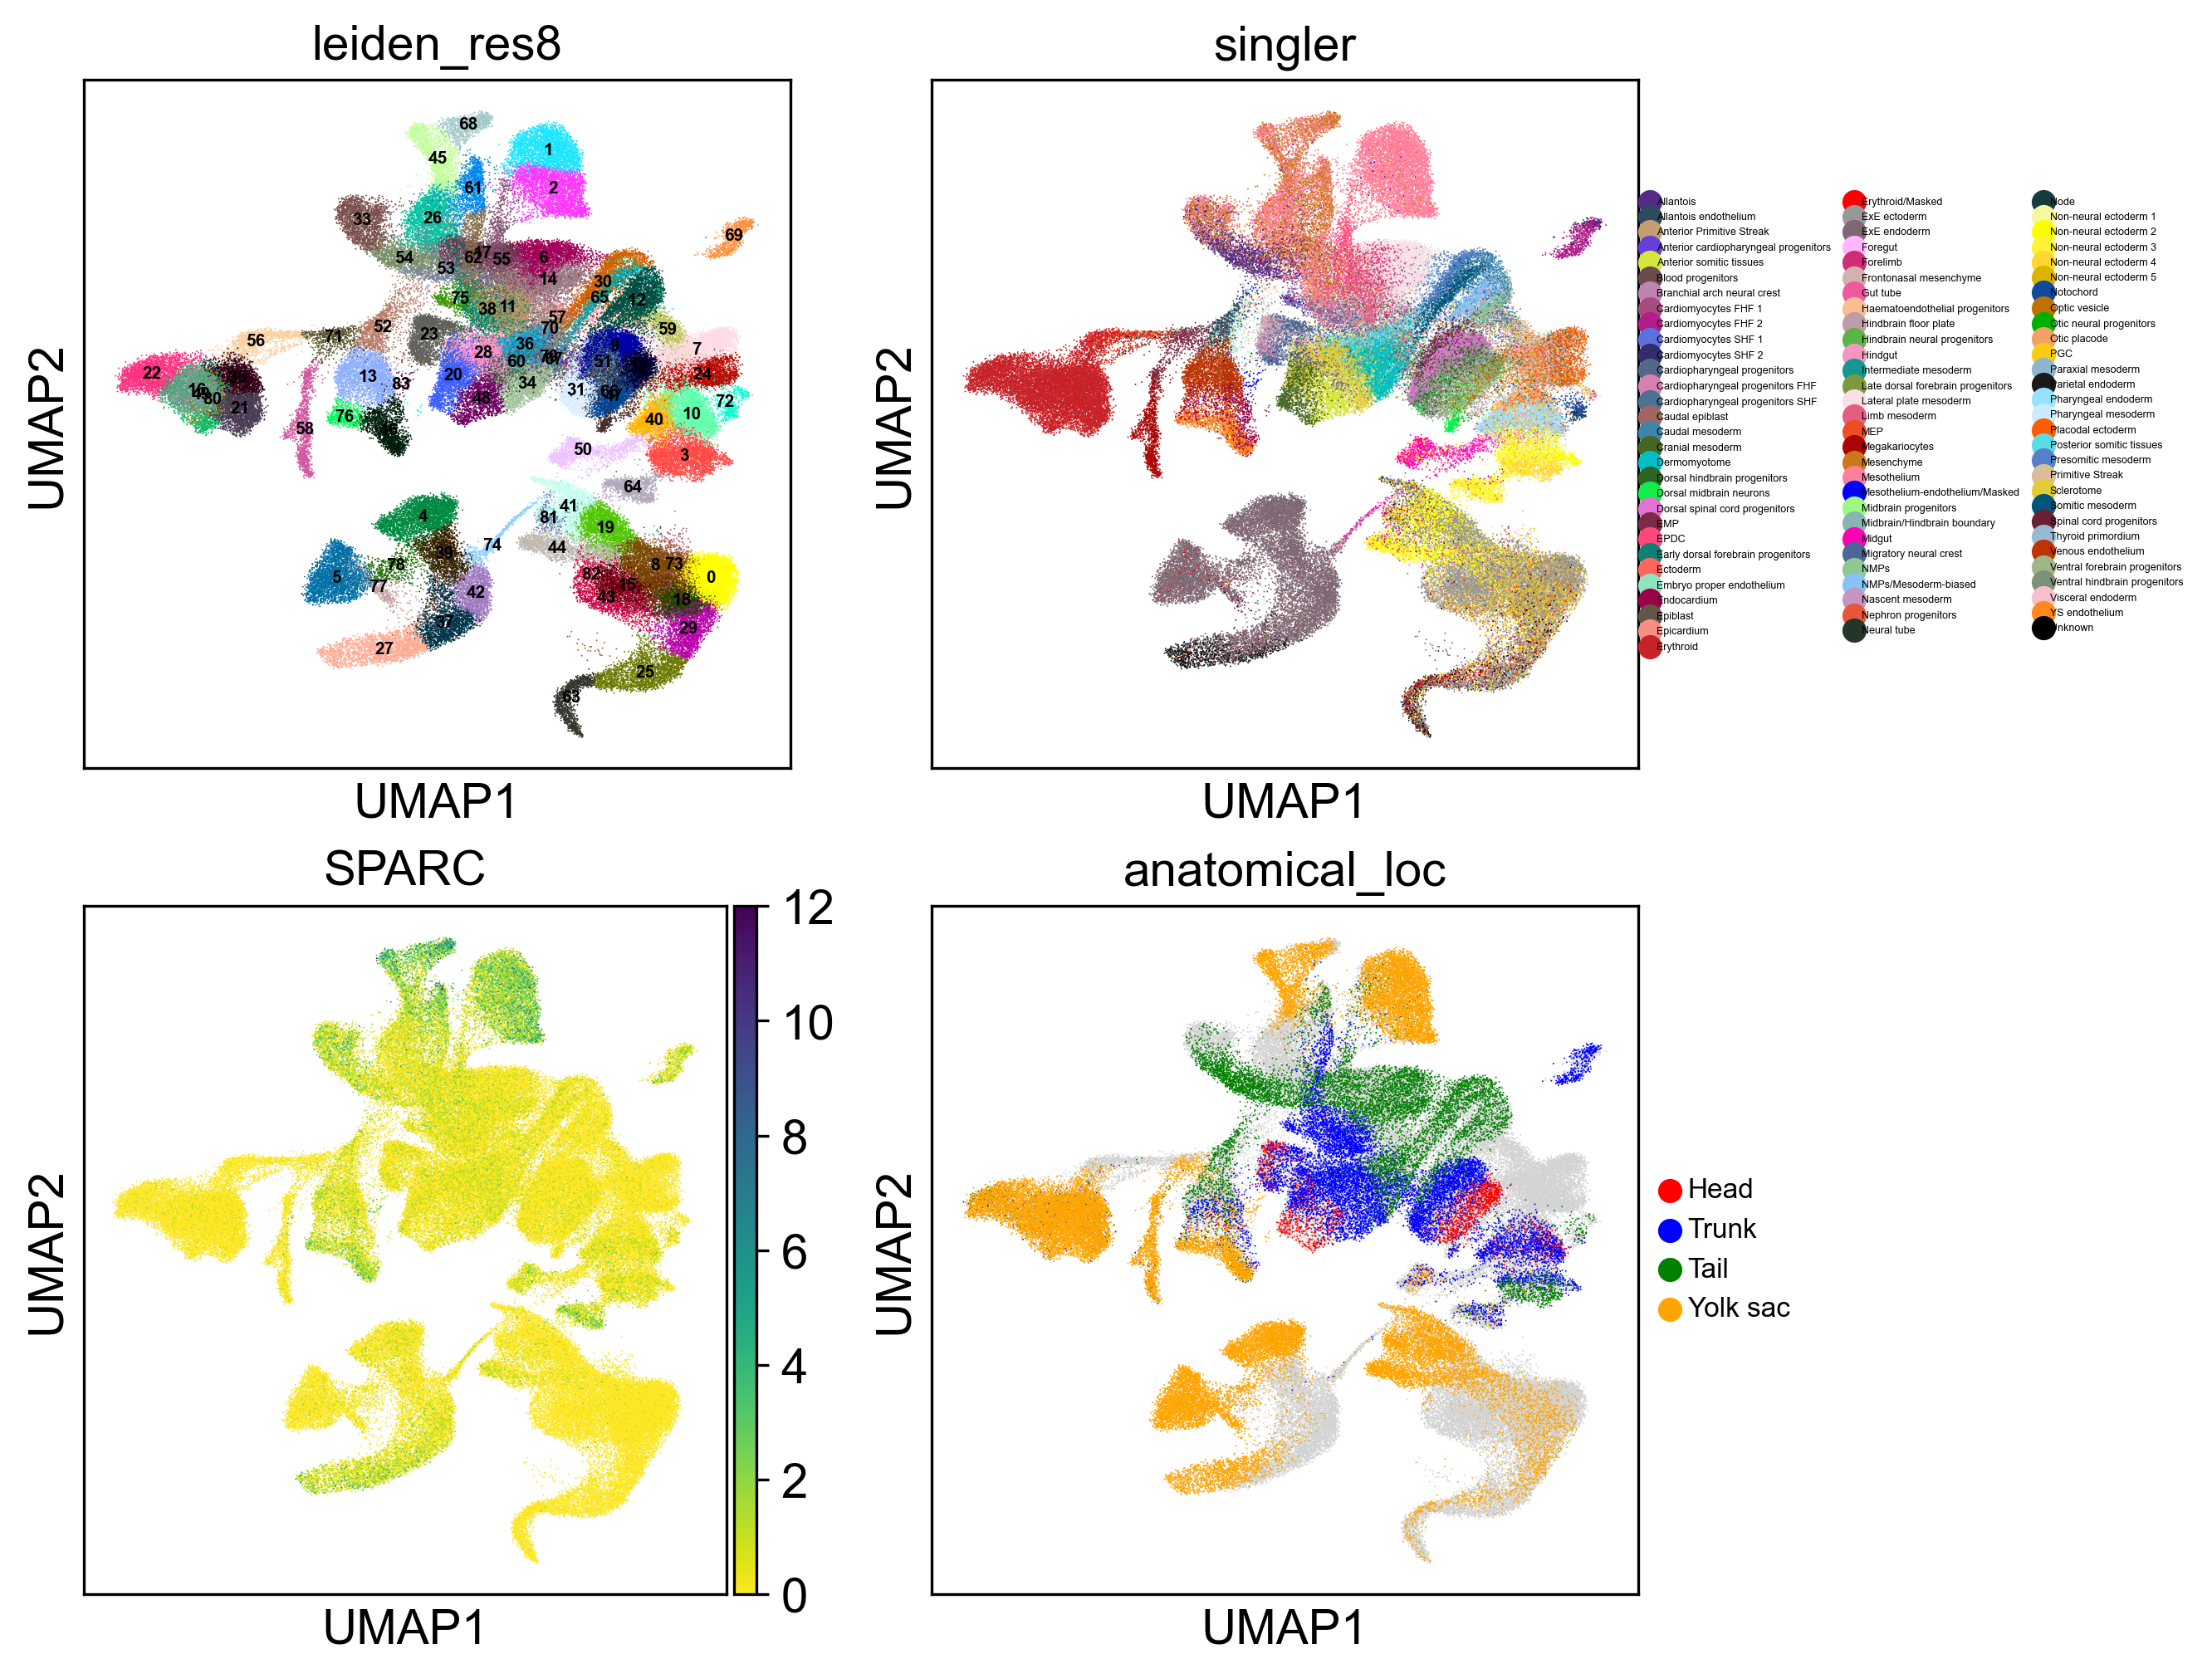

In [229]:
fig, axs = plt.subplots(2, 2,figsize=(8,8))

sc.pl.umap(r_data,color=["leiden_res8"],legend_loc="on data",legend_fontsize=5,ax=axs[0,0],show=False)
sc.pl.umap(r_data,color=["singler"],legend_fontsize=3,ax=axs[0,1],show=False)
sc.pl.umap(r_data,color=r_markers["Yolk sac endothelium"][1],color_map="viridis_r",ax=axs[1,0],show=False)
sc.pl.umap(r_data,color=["anatomical_loc"],groups=["Head","Trunk","Tail","Yolk sac"],legend_fontsize=8,ax=axs[1,1],show=False)


#frac_plot = plotObsFraction(r_data,"")

It's also informative to plot the frequency distribution of cell type predictions within each cluster. Since the annotation model makes predictions independently for each cell, if there are clusters of cells with a common cell type prediction, it may be suggestive of a reliable annotation. Similarly, we can plot the distribution across clusters for each predicted cell type label. 

In [14]:
data = computeObsFraction(r_data, obsA = "leiden_res8", obsB = "singler", obsB_ignore_thresh = 0.02)
data


leiden_res8                         singler  leiden_res8_ncells  \
503              0                           Other                4128   
1847             0                           Other                4128   
2099             0                           Other                4128   
2519             0                           Other                4128   
2687             0                    ExE ectoderm                4128   
...            ...                             ...                 ...   
615720          83                           Other                  74   
617568          83                     Mesothelium                  74   
617652          83  Mesothelium-endothelium/Masked                  74   
620424          83                           Other                  74   
620760          83                           Other                  74   

        singler_count  singler_frac  
503               9.0      0.002180  
1847             37.0      0.008963  
2099              1.0      0.000242  
2519              2.0      0.000484  
2687           2496.0      0.604651  
...               ...           ...  
615720            1.0      0.013514  
617568            2.0      0.027027  
617652           69.0      0.932432  
620424            1.0      0.013514  
620760            1.0      0.013514  

[1687 rows x 5 columns]

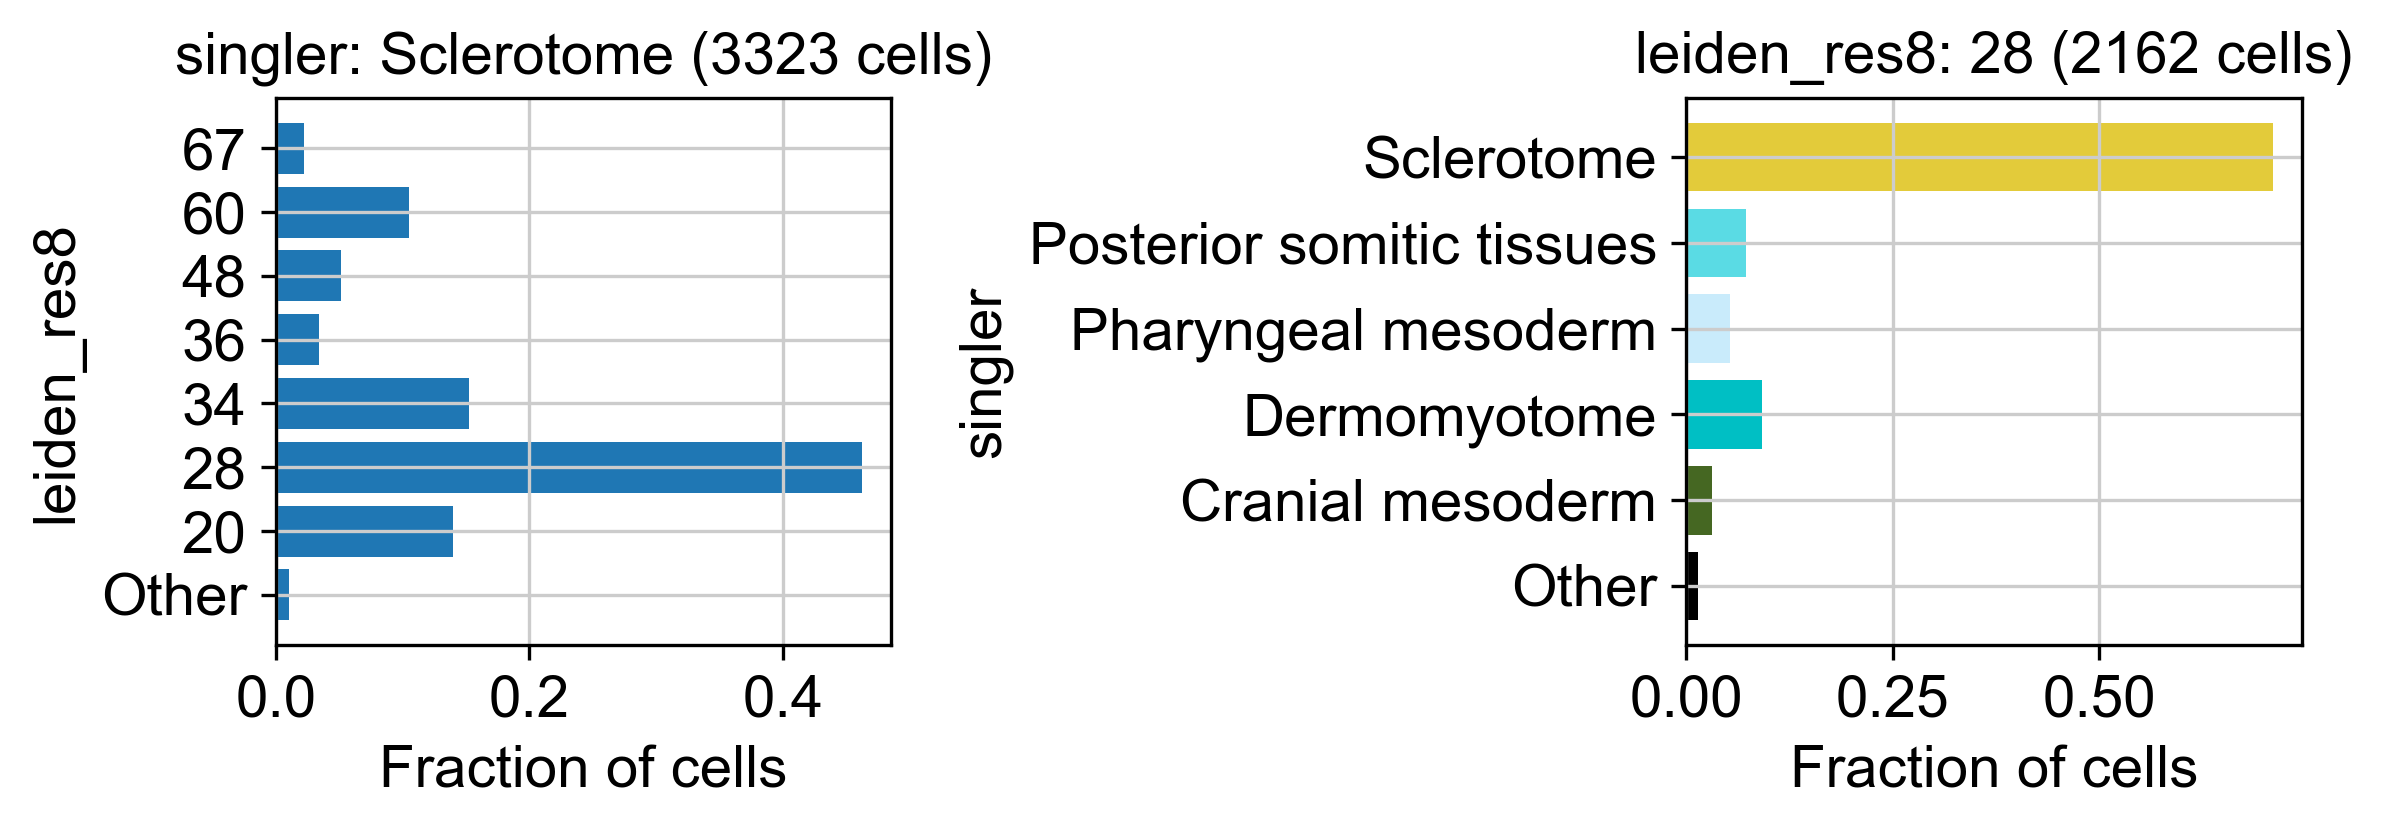

In [26]:
fig, axs = plt.subplots(1, 2,figsize=(8,3))

plotObsFraction(r_data,obA="Sclerotome", obsA = "singler", obsB = "leiden_res8", 
                     obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,ax=axs[0])

plotObsFraction(r_data,obA="28", obsA = "leiden_res8", obsB = "singler", 
                    obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,ax=axs[1],
                obsB_colours=getCelltypePalette())
    

plt.savefig("G:/My Drive/Postgrad/PhD/Assessments/Second year report/figs/src/cluster_fractions.pdf", dpi=300)

### Visualise 3D

Finally, it can also be informative to visualise the embeddings in 3D to reveal structure that may be obfuscated in 2D.  

## Make annotation plots 

We can produce the 2D figures above for each broad region, and for each clustering.  First we do this looking at the whole dataset before then focussing in on each region. 

### Whole dataset

In [ ]:
Path("../figs/celltype_annotation/annotation_pipeline/whole_dataset/").mkdir(parents=True, exist_ok=True)
makeAnnotationPlots(r_data, 
                    clusters = ["leiden_res8"],
                    model_predictions = "singler",
                   markers = r_markers,
                    other_obs = ["stage","anatomical_loc"],
                   export_dir = "../figs/celltype_annotation/annotation_pipeline/whole_dataset/")

In [40]:
annotations = pd.read_csv("../data-in/cell_type_annotation/annotation_12-07-21.tsv",sep="\t",index_col=0)
annotations

updated_celltype
cell_1              Epiblast
cell_2             Hypoblast
cell_4              Epiblast
cell_5       Cytotrophoblast
cell_6       Caudal mesoderm
...                      ...
cell_172991        Erythroid
cell_172992              EMP
cell_172993        Erythroid
cell_172994              EMP
cell_172995          Unknown

[146133 rows x 1 columns]

In [49]:
r_data.obs["celltype"] = r_data.obs["celltype"].astype("category")


In [47]:
r_data.obs["celltype"].loc[r_data.obs["celltype"]=="Forebrain/Eye"] = "Brain/Eye"
r_data.obs["celltype"].loc[r_data.obs["celltype"]=="Hindbrain/Spinal cord"] = "Spinal cord"


C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [50]:
r_data.uns["celltype_colors"] = [getCelltypePalette()[x] for x in r_data.obs["celltype"].cat.categories]

In [62]:
r_data

AnnData object with n_obs × n_vars = 146133 × 30725
    obs: 'cell', 'barcode', 'sample', 'stage', 'batch', 'doub.density', 'doublet', 'stripped', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'sizeFactor', 'celltype', 'singler', 'leiden_res1', 'leiden_res1_5', 'leiden_res2_5', 'leiden_res3', 'leiden_res5', 'leiden_res10', 'leiden_res6', 'leiden_res7', 'leiden_res8', 'anatomical_loc'
    var: 'ensembl_ids'
    uns: 'celltype_colors', 'leiden', 'neighbors', 'singler_colors', 'umap', 'anatomical_loc_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [57]:
r_copy = r_data


In [78]:
r_copy.obs

cell           barcode  sample stage  batch  doub.density  \
cell_1            cell_1  AAACCCAAGCCTTCTC       1   GD7      1      6.367198   
cell_2            cell_2  AAACCCACACAATGAA       1   GD7      1      0.000000   
cell_4            cell_4  AAACCCAGTAGGTTTC       1   GD7      1     43.049333   
cell_5            cell_5  AAACCCATCTGGACTA       1   GD7      1      8.402787   
cell_6            cell_6  AAACGAAAGGTGAGAA       1   GD7      1     61.325550   
...                  ...               ...     ...   ...    ...           ...   
cell_172991  cell_172991  TTTGTTGGTCAAGCCC      26   GD9      1      1.844210   
cell_172992  cell_172992  TTTGTTGTCAAACGTC      26   GD9      1      6.678890   
cell_172993  cell_172993  TTTGTTGTCCCTCTCC      26   GD9      1      2.266589   
cell_172994  cell_172994  TTTGTTGTCGCAACAT      26   GD9      1      7.826140   
cell_172995  cell_172995  TTTGTTGTCGTCGCTT      26   GD9      1     29.612056   

             doublet  stripped cluster  sizeFactor         celltype  \
cell_1         False     False       7    1.215205         Epiblast   
cell_2         False     False      39    0.861057        Hypoblast   
cell_4         False     False       7    0.569989         Epiblast   
cell_5         False     False      15    0.891161  Cytotrophoblast   
cell_6         False     False      59    1.362187  Caudal mesoderm   
...              ...       ...     ...         ...              ...   
cell_172991    False     False      21    0.996563        Erythroid   
cell_172992    False     False      71    1.230563              EMP   
cell_172993    False     False      16    1.195545        Erythroid   
cell_172994    False     False      71    1.291939              EMP   
cell_172995    False     False      44    1.694956          Unknown   

                       singler leiden_res1 leiden_res8 anatomical_loc  day  
cell_1       Placodal ectoderm           7           7   Whole embryo    7  
cell_2            ExE endoderm          13          39   Whole embryo    7  
cell_4       Placodal ectoderm           7           7   Whole embryo    7  
cell_5            ExE ectoderm           0          15   Whole embryo    7  
cell_6        Somitic mesoderm           7          59   Whole embryo    7  
...                        ...         ...         ...            ...  ...  
cell_172991          Erythroid           4          21       Yolk sac    9  
cell_172992                EMP           8          71       Yolk sac    9  
cell_172993          Erythroid           4          16       Yolk sac    9  
cell_172994                EMP           8          71       Yolk sac    9  
cell_172995       ExE ectoderm           9          44       Yolk sac    9  

[146133 rows x 16 columns]

In [74]:
r_copy.obs["cluster"] = r_copy.obs["leiden_res8"]

In [86]:
r_data

AnnData object with n_obs × n_vars = 146133 × 30725
    obs: 'cell', 'barcode', 'sample', 'stage', 'batch', 'doub.density', 'doublet', 'stripped', 'cluster', 'sizeFactor', 'celltype', 'singler', 'leiden_res1', 'leiden_res8', 'anatomical_loc', 'day'
    var: 'ensembl_ids'
    uns: 'celltype_colors', 'leiden', 'neighbors', 'singler_colors', 'umap', 'anatomical_loc_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [80]:
stage_dict = {"GD7":7,"GD8":8,"GD9":9}
r_data.obs['day'] = r_data.obs['stage'].replace(stage_dict)

In [85]:
r_data.write("../data-in/rabbit/anndata_new.h5ad")

### Mesoderm

In [27]:
# Compute subset specific clustering
sc.tl.leiden(r_meso, resolution=2, key_added="mesoderm_leiden_res2", random_state = seed)
sc.tl.leiden(r_meso, resolution=5, key_added="mesoderm_leiden_res3", random_state = seed)

C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\tools\_leiden.py:111: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [48]:
# Create directory for mesoderm region
#Path("../figs/celltype_annotation/annotation_pipeline/r_meso/").mkdir(parents=True, exist_ok=True)

# Filter out cell types unlikely to be in mesodermal region 
mesoderm_celltypes = ["Anterior cardiopharyngeal progenitors","Anterior somitic tissues","Branchial arch neural crest",
                     "Cardiomyocytes FHF 1", "Cardiomyocytes FHF 2", "Cardiomyocytes SHF 1","Cardiomyocytes SHF 2",
                     "Cardiopharyngeal progenitors", 'Cardiopharyngeal progenitors SHF','Cranial mesoderm',
                     "Dermomyotome","Epicardium","ExE mesoderm","Frontonasal mesenchyme","Kidney",'Lateral plate mesoderm','Limb mesoderm',
                     "Mesenchyme","Migratory neural crest","Myocardium",'Nephron progenitors','Posterior somitic tissues','Sclerotome']


makeAnnotationPlots(r_meso, 
                    clusters = ["leiden_res8", "mesoderm_leiden_res2","mesoderm_leiden_res3"],
                    model_predictions = "singler", other_obs=["stage","anatomical_loc"],
                   markers = {k: r_markers[k] for k in mesoderm_celltypes},
                   export_dir = "../figs/celltype_annotation/annotation_pipeline/r_meso/")

### Blood

In [334]:
# Compute subset specific clustering
sc.tl.leiden(r_blood, resolution=1, key_added="blood_leiden_res1", random_state = seed)
sc.tl.leiden(r_blood, resolution=8, key_added="blood_leiden_res8", random_state = seed)

C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\tools\_leiden.py:111: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [335]:
# Create directory for mesoderm region
Path("../figs/celltype_annotation/annotation_pipeline/r_blood/").mkdir(parents=True, exist_ok=True)

# Filter out cell types unlikely to be in blood region 
blood_celltypes = ['Allantois endothelium','Embryo proper endothelium','EMP','Endocardium',
                   'Megakaryocyte progenitors','MEP','Venous endothelium','Yolk sac endothelium']


makeAnnotationPlots(r_blood, 
                    clusters = ["leiden_res8", "blood_leiden_res1","blood_leiden_res8"],
                    model_predictions = "singler", other_obs=["stage","anatomical_loc"],
                   markers = {k: r_markers[k] for k in blood_celltypes},
                   export_dir = "../figs/celltype_annotation/annotation_pipeline/r_blood/")


## Assign cell types

By manually inspecting all of this information, we then determine the most-likely identity for each cluster. 

### Mesoderm

In [36]:
meso_umap3D = sc.pp.neighbors(r_meso,n_neighbors=50, use_rep="X_pca", random_state=seed, copy=True)
meso_umap3D = sc.tl.umap(meso_umap3D, min_dist=0.5, n_components=3, random_state=seed, copy=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\tools\_umap.py:147: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.



In [331]:
from ipywidgets.widgets import HBox

fig1 = plotObsUMAP3d(meso_umap3D,"singler",scrabbit.plot_utils.getCelltypePalette(),figsize=(700,700))
fig2 = plotObsUMAP3d(meso_umap3D,"mesoderm_leiden_res3",scrabbit.plot_utils.getClusterPalette(),figsize=(700,700))
HBox([go.FigureWidget(fig1), go.FigureWidget(fig2)])


    'data': [{'marker': {'color': '#532C8A', 'size': 2},
              'mode': '…

In [525]:
r_meso.obs["assigned_celltype"] = r_meso.obs["assigned_celltype"].astype(str)
r_data.obs["assigned_celltype"] = r_data.obs["assigned_celltype"].astype(str)

r_meso.obs["assigned_celltype"] = "Unknown"

# Perform assignment
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["16"], "assigned_celltype", "Cardiomyocytes FHF 2")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["36"], "assigned_celltype", "Cardiomyocytes FHF 1")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["23","5","47","44"], "assigned_celltype", "Cranial mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["10","40"], "assigned_celltype", "Anterior somitic tissues")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["35"], "assigned_celltype", "Anterior cardiopharyngeal progenitors")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["2"], "assigned_celltype", "NMPs/Mesoderm-biased")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["0"], "assigned_celltype", "NMPs")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["12"], "assigned_celltype", "Caudal mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["6"], "assigned_celltype", "Presomitic mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["18","41"], "assigned_celltype", "Somitic mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["3","15","7","4","43","42"], "assigned_celltype", "Dermomyotome")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["17","49"], "assigned_celltype", "Posterior somitic tissues")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["13","21","26","22"], "assigned_celltype", "Sclerotome")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["9","25","24","48","14","1","28","30","31","45"], "assigned_celltype", "Lateral plate mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["20"], "assigned_celltype", "Nephron progenitors") # might need to change to kidney primordium
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["32","19"], "assigned_celltype", "Mesothelium") # might need to change to Embryo proper mesothelium
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["35","33","27","38","39","37","34"], "assigned_celltype", "Cardiopharyngeal progenitors")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["29","46"], "assigned_celltype", "Mesenchyme") 
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["11"], "assigned_celltype", "Limb mesoderm") 
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res3", ["8"], "assigned_celltype", "Epicardium") 


In [ ]:
meso_umap3D.obs["assigned_celltype"] = r_meso.obs["assigned_celltype"]

plotObsUMAP3d(meso_umap3D,"assigned_celltype",figsize=(1200,700),
              hover_obs=["singler","mesoderm_leiden_res3","anatomical_loc","stage","leiden_res8"],
              colour_map=scrabbit.plot_utils.getCelltypePalette())

### Blood

In [336]:
blood_umap3D = sc.pp.neighbors(r_blood,n_neighbors=50, use_rep="X_pca", random_state=seed, copy=True)
blood_umap3D = sc.tl.umap(blood_umap3D, min_dist=0.5, n_components=3, random_state=seed, copy=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\neighbors\__init__.py:121: FutureWarning:

This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.

C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\neighbors\__init__.py:122: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\tools\_umap.py:147: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.



In [471]:
from ipywidgets.widgets import HBox

fig1 = plotObsUMAP3d(blood_umap3D,"singler",hover_obs=["singler","blood_leiden_res8","anatomical_loc","stage","leiden_res8"],
                    colour_map=scrabbit.plot_utils.getCelltypePalette(),figsize=(700,700))
fig2 = plotObsUMAP3d(blood_umap3D,"blood_leiden_res8",
                     hover_obs=["blood_leiden_res8","singler","anatomical_loc","stage","leiden_res8"],
                     figsize=(700,700))
HBox([go.FigureWidget(fig1), go.FigureWidget(fig2)])


    'data': [{'customdata': [['Allantois endothelium', '5', 'Whole embryo', 'GD7…

In [526]:
r_blood.obs["assigned_celltype"] = "Unknown"

assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res1", ["3","2","9","0","4"], "assigned_celltype", "Erythroid")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["10","53","60","32","22","23","57","44","28","51","21"], "assigned_celltype", "Erythroid")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["14","19","52"], "assigned_celltype", "Megakariocytes")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["37","1"], "assigned_celltype", "EMP")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["0","36","58","6","30"], "assigned_celltype", "YS endothelium")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["24","5"], "assigned_celltype", "Allantois endothelium")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["49"], "assigned_celltype", "Endocardium")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["4","8","12","18","3","50","62"], "assigned_celltype", "Venous endothelium")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["2"], "assigned_celltype", "MEP")
assignCelltypeAdataSubset(r_data, r_blood, "blood_leiden_res8", ["55","29"], "assigned_celltype", "Embryo proper endothelium")

In [ ]:
blood_umap3D.obs["assigned_celltype"] = r_blood.obs["assigned_celltype"]

plotObsUMAP3d(blood_umap3D,"assigned_celltype",figsize=(1200,700),
              hover_obs=["singler","blood_leiden_res8","anatomical_loc","stage","leiden_res8"],
              colour_map=scrabbit.plot_utils.getCelltypePalette())

### Extra-embryonic mesoderm

In [492]:
sc.tl.leiden(r_exeMeso,resolution=1,key_added="exeMeso_leiden_res1",random_state=seed)

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [488]:
exeMeso_3d = sc.pp.neighbors(r_exeMeso,n_neighbors=50, use_rep="X_pca", random_state=seed, copy=True)
exeMeso_3d = sc.tl.umap(exeMeso_3d, min_dist=0.5, n_components=3, random_state=seed, copy=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\neighbors\__init__.py:121: FutureWarning:

This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.

C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\neighbors\__init__.py:122: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\tools\_umap.py:147: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.



In [495]:
fig1 = plotObsUMAP3d(exeMeso_3d,"singler",
                     hover_obs=["singler","exeMeso_leiden_res1","anatomical_loc","stage","leiden_res8"],
                    colour_map=scrabbit.plot_utils.getCelltypePalette(),figsize=(700,600))

fig2 = plotObsUMAP3d(exeMeso_3d,"exeMeso_leiden_res1",
                     hover_obs=["exeMeso_leiden_res1","singler","anatomical_loc","stage","leiden_res8"],
                     figsize=(700,600))
HBox([go.FigureWidget(fig1), go.FigureWidget(fig2)])


    'data': [{'customdata': [['Mesenchyme', '2', 'Whole embryo', 'GD8', '26'],
 …

In [527]:
r_exeMeso.obs["assigned_celltype"] = "Unknown"

assignCelltypeAdataSubset(r_data, r_exeMeso, "exeMeso_leiden_res1", ["0","1","9"], "assigned_celltype", "Mesothelium")
assignCelltypeAdataSubset(r_data, r_exeMeso, "exeMeso_leiden_res1", ["10"], "assigned_celltype", "Mesothelium-endothelium/Masked")
assignCelltypeAdataSubset(r_data, r_exeMeso, "exeMeso_leiden_res1", ["3","4"], "assigned_celltype", "Allantois")
assignCelltypeAdataSubset(r_data, r_exeMeso, "exeMeso_leiden_res1", ["8","7"], "assigned_celltype", "Mesenchyme")

In [ ]:
exeMeso_3d.obs["assigned_celltype"] = r_exeMeso.obs["assigned_celltype"]

plotObsUMAP3d(exeMeso_3d,"assigned_celltype",figsize=(1200,700),
              hover_obs=["singler","exeMeso_leiden_res1","anatomical_loc","stage","leiden_res8"],
              colour_map=scrabbit.plot_utils.getCelltypePalette())

### Neural

In [553]:
sc.tl.leiden(r_neural,resolution=5,key_added="neural_leiden_res5",random_state=seed)

In [554]:
neural_3d.obs["neural_leiden_res5"] = r_neural.obs["neural_leiden_res5"]

In [543]:
neural_3d = sc.pp.neighbors(r_neural,n_neighbors=50, use_rep="X_pca", random_state=seed, copy=True)
neural_3d = sc.tl.umap(neural_3d, min_dist=0.5, n_components=3, random_state=seed, copy=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\neighbors\__init__.py:121: FutureWarning:

This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.

C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\neighbors\__init__.py:122: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\tools\_umap.py:147: FutureWarning:

This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.



In [571]:
fig1 = plotObsUMAP3d(neural_3d,"singler",
                     hover_obs=["singler","neural_leiden_res2","anatomical_loc","stage","leiden_res8"],
                    colour_map=scrabbit.plot_utils.getCelltypePalette(),figsize=(700,600))

fig2 = plotObsUMAP3d(neural_3d,"neural_leiden_res3",
                     hover_obs=["neural_leiden_res3","singler","anatomical_loc","stage","leiden_res8"],
                     figsize=(700,600))

HBox([go.FigureWidget(fig1), go.FigureWidget(fig2)])

    'data': [{'customdata': [['Placodal ectoderm', '1', 'Whole embryo', 'GD7',
 …

In [ ]:
plotObsUMAP3d(neural_3d,"TBXT",
                     hover_obs=["neural_leiden_res3","singler","anatomical_loc","stage","leiden_res8"],
                     figsize=(700,600))

In [ ]:
r_neural.obs["assigned_celltype"] = "Unknown"

assignCelltypeAdataSubset(r_data, r_neural, "neural_leiden_res3", ["14"], "assigned_celltype", "Floor plate")
assignCelltypeAdataSubset(r_data, r_neural, "neural_leiden_res3", ["23"], "assigned_celltype", "Differentiating neurons") # Differentiating neurons
assignCelltypeAdataSubset(r_data, r_neural, "neural_leiden_res3", ["12","1","11","21"], "assigned_celltype", "Spinal cord progenitors")
assignCelltypeAdataSubset(r_data, r_neural, "neural_leiden_res3", ["19","4","7"], "assigned_celltype", "Forebrain/Eye")
assignCelltypeAdataSubset(r_data, r_neural, "neural_leiden_res3", ["0","5","16"], "assigned_celltype", "Epiblast")
assignCelltypeAdataSubset(r_data, r_neural, "neural_leiden_res3", ["15","10"], "assigned_celltype", "Primitive Streak")


"""
rabbit.obs.loc[neural.obs.index[neural.obs["neural_leiden_res2"].isin(["5","2","7","1"])],"updated_celltype"] = "Hindbrain/Spinal cord"
rabbit.obs.loc[neural.obs.index[neural.obs["neural_leiden_res2"].isin(["17"])],"updated_celltype"] = "Differentiating neurons" # Previously dorsal midbrain neurons
rabbit.obs.loc[neural.obs.index[neural.obs["neural_leiden_res2"].isin(["8","4","15"])],"updated_celltype"] = "Forebrain/Eye"
rabbit.obs.loc[neural.obs.index[neural.obs["neural_leiden_res2"].isin(["0","3","18","11","6","16"])],"updated_celltype"] = "Epiblast"
rabbit.obs.loc[neural.obs.index[neural.obs["neural_leiden_res2"].isin(["14"])],"updated_celltype"] = "Floor plate" # See Shh expression

rabbit.obs.loc[neural.obs.index[neural.obs["neural_leiden_res2"].isin(["9","13"])],"updated_celltype"] = "Neural tube" # Really not sure, try to come back to this


rabbit.obs.loc[neural.obs.index[neural.obs["neural_leiden_res5"].isin(["11"])],"updated_celltype"] = "Primitive Streak"
rabbit.obs.loc[neural.obs.index[neural.obs["neural_leiden_res5"].isin(["22","31"])],"updated_celltype"] = "Caudal mesoderm"

"""

In [ ]:
neural_3d.obs["assigned_celltype"] = r_neural.obs["assigned_celltype"]

plotObsUMAP3d(neural_3d,"assigned_celltype",figsize=(1200,700),
              hover_obs=["singler","neural_leiden_res3","anatomical_loc","stage","leiden_res8"],
              colour_map=scrabbit.plot_utils.getCelltypePalette())

### Ectoderm/Endoderm 

### Extra-embryonic endoderm

In [532]:
sc.tl.leiden(r_misc,resolution=2,key_added="misc_leiden_res2",random_state=seedB)

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


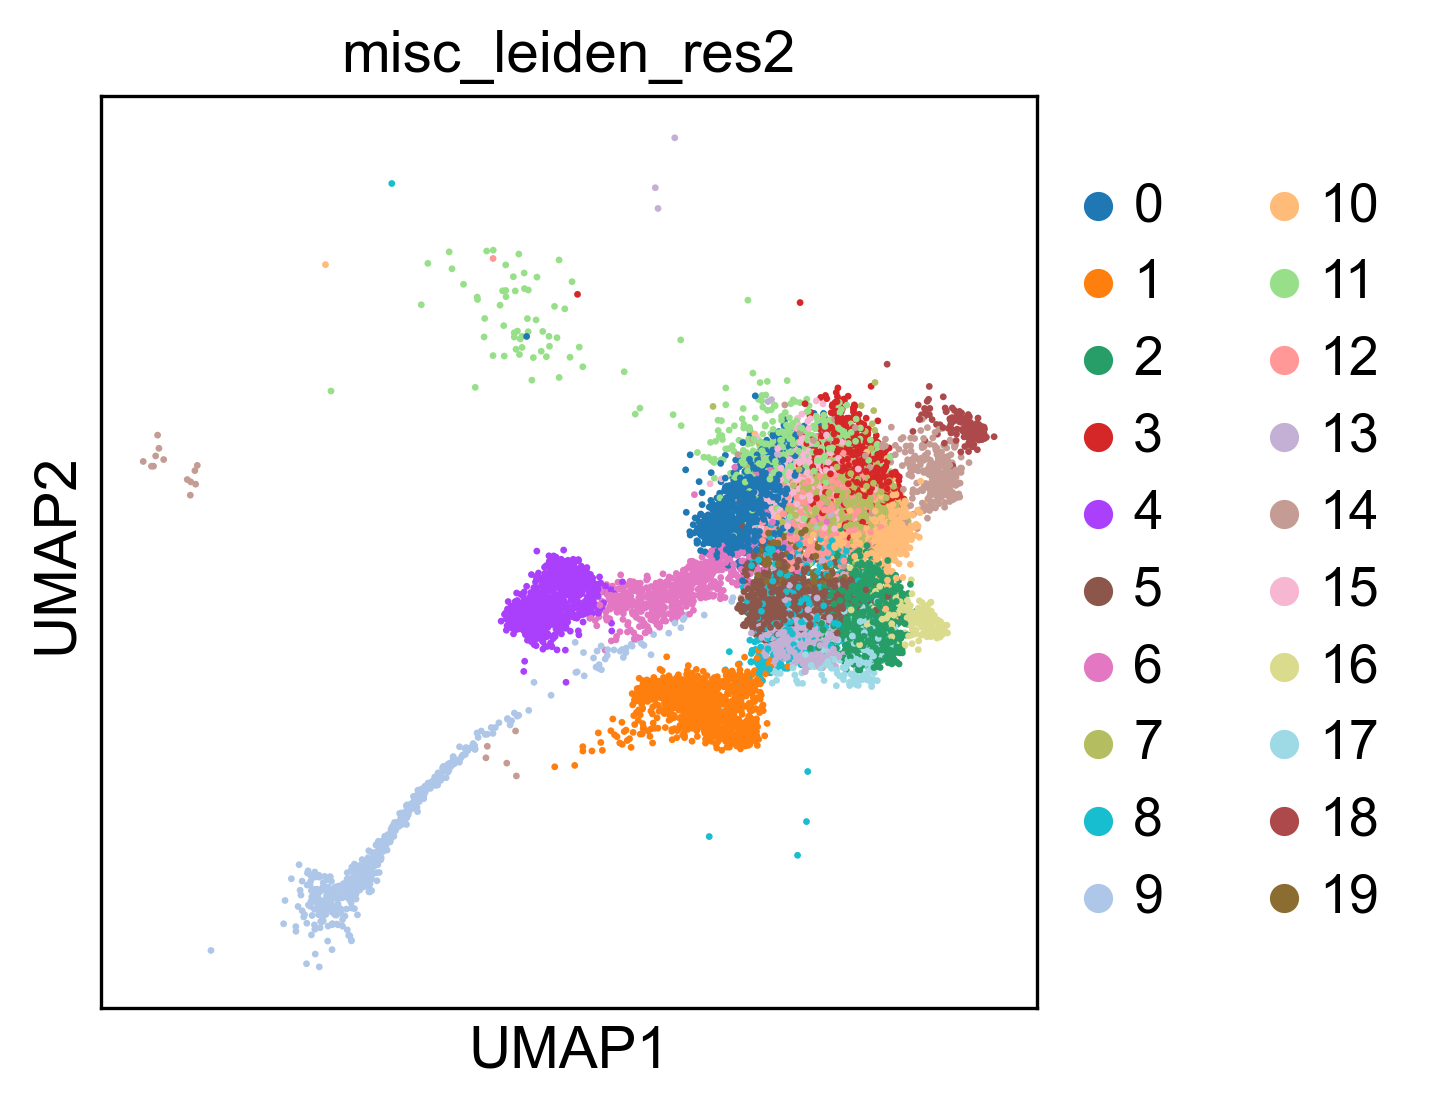

In [533]:
sc.pl.umap(r_misc,color="misc_leiden_res2")

In [537]:
r_misc.obs["assigned_celltype"] = "Unknown"

assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["9"], "assigned_celltype", "Visceral endoderm")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["6"], "assigned_celltype", "Gut tube")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["4"], "assigned_celltype", "Midgut")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["0","12","7","3","15"], "assigned_celltype", "Pharyngeal endoderm")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["11"], "assigned_celltype", "Otic placode")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["18"], "assigned_celltype", "PGC")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["1"], "assigned_celltype", "Non-neural ectoderm 3")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["10"], "assigned_celltype", "Thyroid primordium")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["16","8","19"], "assigned_celltype", "Non-neural ectoderm 2")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["5","2"], "assigned_celltype", "Non-neural ectoderm 2")
assignCelltypeAdataSubset(r_data, r_misc, "misc_leiden_res2", ["17","13"], "assigned_celltype", "Non-neural ectoderm 4")


# Node/Notchord
#rabbit.obs.loc[noto.obs.index[noto.obs["noto_leiden_res1"].isin(["0"])],"updated_celltype"] = "Node" 
#rabbit.obs.loc[noto.obs.index[noto.obs["noto_leiden_res1"].isin(["4","3","2"])],"updated_celltype"] = "Notochord" 

'\n\n\n\n# Node/Notchord\nrabbit.obs.loc[noto.obs.index[noto.obs["noto_leiden_res1"].isin(["0"])],"updated_celltype"] = "Node" \nrabbit.obs.loc[noto.obs.index[noto.obs["noto_leiden_res1"].isin(["4","3","2"])],"updated_celltype"] = "Notochord" \n\n'

### Extra-embryonic ectoderm


In [573]:
r_data.obs["assigned_celltype"] = r_data.obs["assigned_celltype"].astype("str")


In [524]:
r_data.obs["assigned_celltype"] = "Unknown"

In [539]:
r_data.obs["assigned_celltype"] = r_data.obs["assigned_celltype"].astype("category")
cmap = scrabbit.plot_utils.getCelltypePalette()
r_data.uns["assigned_celltype_colors"] = [cmap[x] for x in r_data.obs["assigned_celltype"].cat.categories]

In [528]:
r_data.obs["assigned_celltype"]

cell_1           Unknown
cell_2           Unknown
cell_4           Unknown
cell_5           Unknown
cell_6           Unknown
                 ...    
cell_172991    Erythroid
cell_172992          EMP
cell_172993    Erythroid
cell_172994          EMP
cell_172995      Unknown
Name: assigned_celltype, Length: 146133, dtype: object

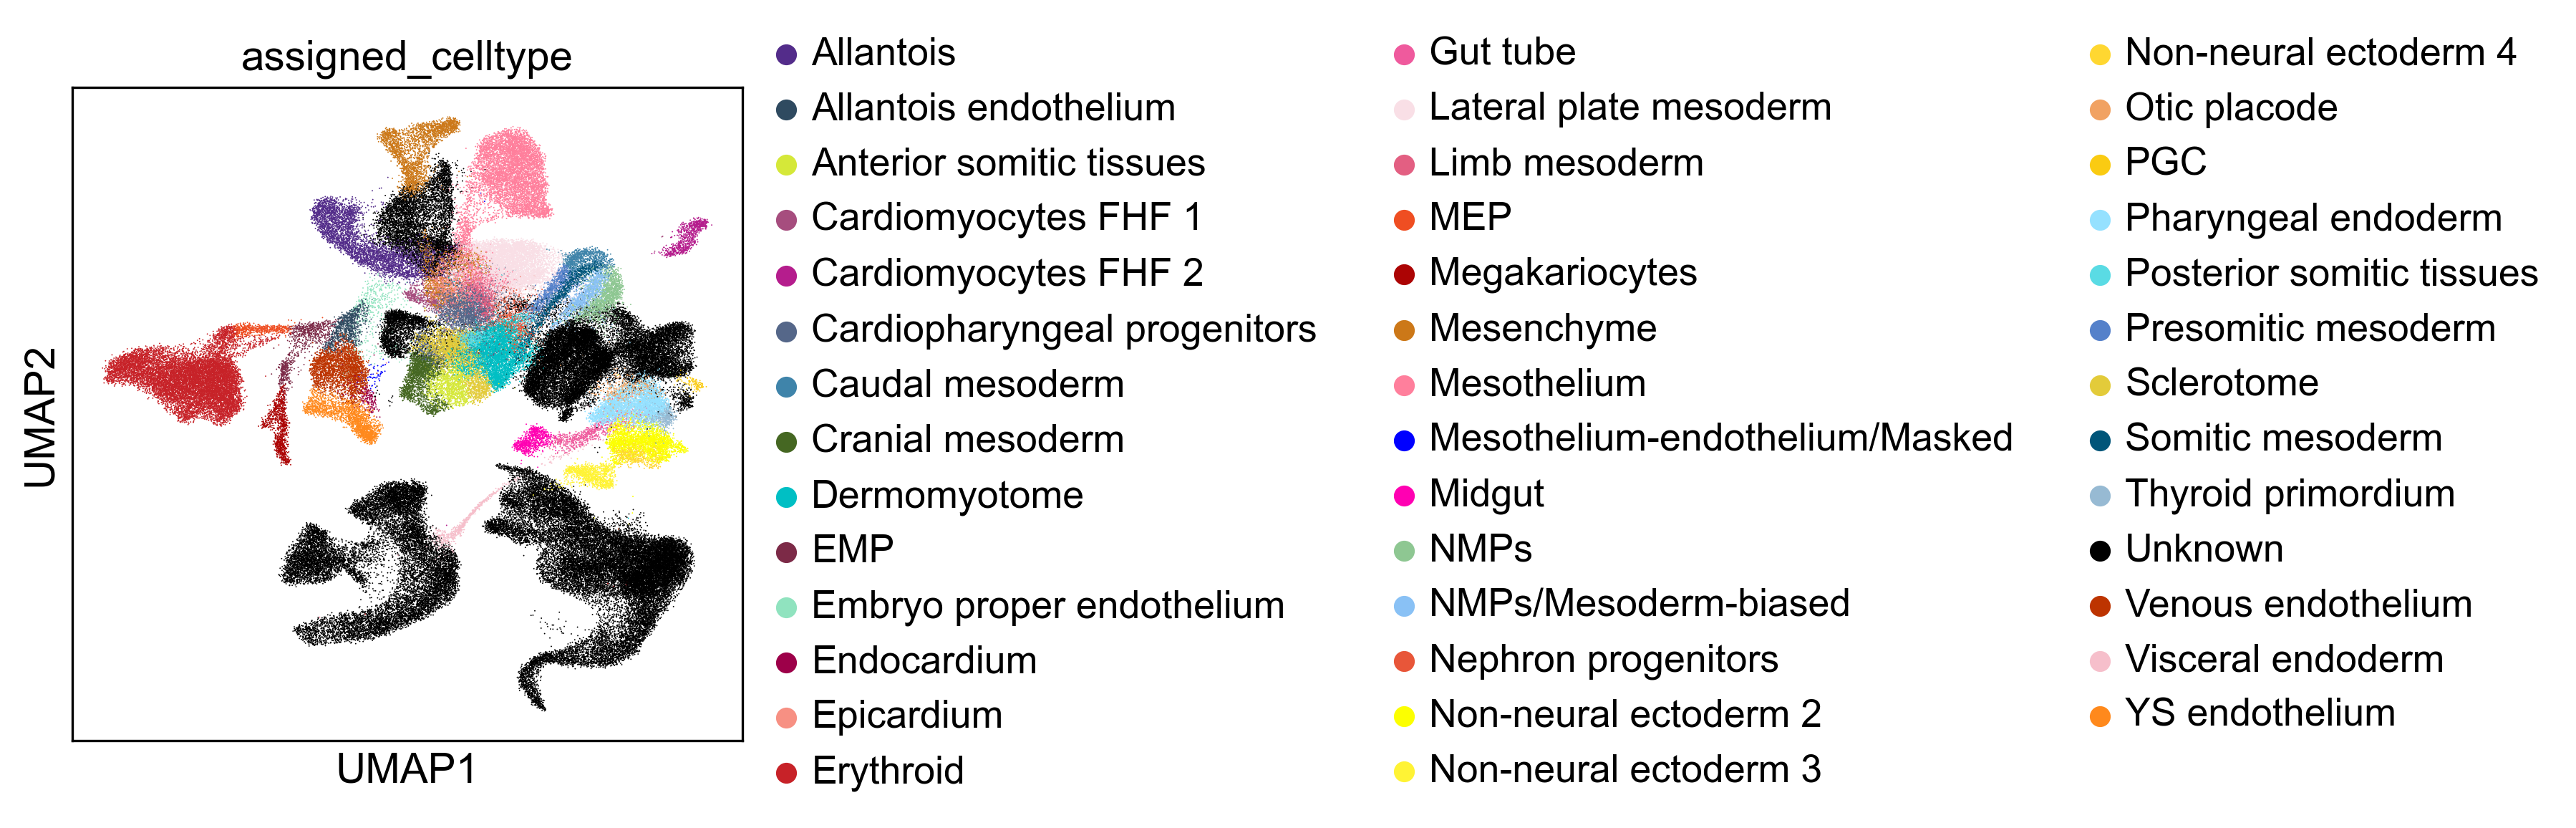

In [540]:
sc.pl.umap(r_data,color="assigned_celltype")

In [87]:
sc.AnnData(pd.DataFrame(r_data.obsm["X_pca"]).set_index(0)

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_27024/1920036820.py, line 1)

In [94]:
sc.AnnData(pd.DataFrame(r_data.obsm["X_pca"]),
                                     obs=r_data.obs)

C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 146133 × 50
    obs: 'cell', 'barcode', 'sample', 'stage', 'batch', 'doub.density', 'doublet', 'stripped', 'cluster', 'sizeFactor', 'celltype', 'singler', 'leiden_res1', 'leiden_res8', 'anatomical_loc', 'day'

In [93]:
pd.DataFrame(r_data.obsm["X_pca"]).set_index(0)

1         2         3         4         5         6   \
0                                                                       
 0.113429  0.013276  0.007079  0.042921  0.044488 -0.085002  0.029264   
-0.149560 -0.100811 -0.108933  0.160719  0.052735 -0.010689 -0.043095   
 0.094502 -0.000423 -0.015662  0.016961  0.038863 -0.084900  0.017388   
-0.002569  0.109949  0.007989 -0.144542  0.003043 -0.024960 -0.032781   
 0.104522 -0.001368  0.003455  0.036410  0.010132 -0.049409 -0.015522   
...             ...       ...       ...       ...       ...       ...   
-0.003419  0.010147  0.303531  0.082243 -0.055757 -0.078220 -0.035664   
 0.082331 -0.021928  0.070872 -0.009431 -0.042079 -0.048492 -0.109180   
 0.014335  0.027385  0.313095  0.062561 -0.060215 -0.066000 -0.033989   
 0.071250 -0.013068  0.071395 -0.007128 -0.052914 -0.063399 -0.116879   
-0.025476 -0.031213 -0.060604 -0.193994  0.000804 -0.030600  0.022446   

                 7         8         9         10  ...        40        41  \
0                                                  ...                       
 0.113429 -0.020293  0.008493  0.021363  0.062886  ... -0.012479 -0.021424   
-0.149560  0.058466  0.018372  0.046051  0.047352  ... -0.056267  0.023162   
 0.094502 -0.026245  0.003194  0.038240  0.055388  ... -0.001992 -0.027887   
-0.002569  0.099514  0.020894  0.045174  0.096523  ... -0.003628  0.002675   
 0.104522  0.042678 -0.074843  0.026439  0.028923  ...  0.004929 -0.012735   
...             ...       ...       ...       ...  ...       ...       ...   
-0.003419  0.000429  0.013848  0.085430  0.047119  ... -0.007688  0.040766   
 0.082331  0.005822 -0.031151 -0.029465  0.027603  ...  0.006141 -0.008184   
 0.014335  0.013506  0.014584  0.086086  0.042974  ... -0.003366  0.021448   
 0.071250  0.021198 -0.004867 -0.037230  0.029350  ...  0.009850 -0.001291   
-0.025476 -0.003026  0.018518  0.062989  0.143201  ... -0.055309  0.055719   

                 42        43        44        45        46        47  \
0                                                                       
 0.113429 -0.022411 -0.000120  0.005477 -0.031606 -0.012117 -0.010903   
-0.149560  0.100800  0.036815 -0.052331  0.024430 -0.014060 -0.026085   
 0.094502  0.003961  0.028646  0.009365 -0.007994  0.001145 -0.009136   
-0.002569  0.049203  0.054685 -0.028729  0.018378  0.010688 -0.015744   
 0.104522  0.020782  0.004554  0.017174 -0.012475 -0.004734  0.006467   
...             ...       ...       ...       ...       ...       ...   
-0.003419  0.023612  0.005600 -0.043226  0.045153  0.024497 -0.018540   
 0.082331 -0.001126  0.035298  0.008637 -0.010157  0.013261 -0.010365   
 0.014335  0.020499  0.010267 -0.021491  0.033729  0.028197 -0.016550   
 0.071250 -0.001756  0.033392  0.010713 -0.008348  0.003946 -0.020522   
-0.025476  0.004883  0.011739 -0.013998  0.001876  0.013815  0.024979   

                 48        49  
0                              
 0.113429  0.005465 -0.003550  
-0.149560  0.001639 -0.048954  
 0.094502 -0.008444 -0.003266  
-0.002569 -0.006803 -0.007141  
 0.104522  0.000479  0.012212  
...             ...       ...  
-0.003419 -0.024406 -0.008529  
 0.082331 -0.004111 -0.002749  
 0.014335 -0.014623 -0.009516  
 0.071250  0.003918 -0.001025  
-0.025476  0.004803 -0.015150  

[146133 rows x 49 columns]

In [116]:


exportGMT(r_data,"celltype","G:/My Drive/Postgrad/PhD/Projects/rabbit-gastrulation-atlas/RabbitGastrulation2021/data-test/trajectory_analysis/celltypes.gmt")